# The Chambolle-Pock Primal-Dual Algorithm

**STANGELAND Aleksander (5GMM)**

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
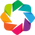

In [1]:
import numpy as np
import numpy.linalg as npl
import scipy as scp
import pylab as pyl
import pywt
import pandas as pd
import holoviews as hv
import param
import panel as pn
import matplotlib.pyplot as plt
import requests
from panel.pane import LaTeX
hv.extension('bokeh')
import warnings
warnings.filterwarnings('ignore')
from PIL import Image
from io import BytesIO
from numpy.fft import fft2, ifft2, fftshift

## General problem

This algorithm is a first-order primal-dual algorithm used to solve convex optimization problems with known saddle-point structure.

Let $X$, $Y$ be two finite-dimensional real vector spaces equipped with an inner
product $\langle ·,· \rangle$, and norm $||·|| = \langle ·,· \rangle^{\frac{1}{2}}$. The map $K : X \to Y$ is a continuous
linear operator with induced norm

$$||K|| = \textrm{max}\{ ||K||: x\in X \;\; \textrm{with} \;\; ||x|| \leq 1\}$$

The general problem we consider in this paper is the generic saddle-point problem

$$\min_{x\in X}\max_{y \in Y} \langle Kx,y \rangle + G(x) -F^*(y)$$

where $G:X\to[0,+\infty)$ and $F^*:Y\to[0,+\infty)$ are proper, convex, lowersemicontinuous (l.s.c.) functions, $F^*$ being itself the convex conjugate of a convex l.s.c. function $F$.

The saddle-point problem is primal-dual formulation of the nonlinear primal problem

$$\min_{x\in X} F(Kx) + G(x)$$

or of the corresponding dual problem
$$\max_{y \in Y} - ( G^*(-K^*y) + F^*(y) )$$

**Algorithm 1**

Initialization: choose $\tau$, $\sigma > 0$, $(x_0,y_0)\in X\times Y$ and set $\bar{x}_0 = x_0$.

Iterations $(n \geq 0)$: Update $x_n$, $y_n$, $\bar{x}_n$ as follows:

$$\begin{cases}
y_{n+1} = \textrm{prox}_{\sigma F^*} (y_n +\sigma K \bar{x}_n) \\
x_{n+1} = \textrm{prox}_{\tau G} (x_n - \tau K^* y_{n+1}) \\
\bar{x}_{n+1} = x_{n+1} -x_n
\end{cases}$$

Data are available online but if you have downloaded them, you can work online changing the value of the variable "local" in the next cell.

In [2]:
def chargeData(name):
    if name=='Lenna':
        url='https://plmlab.math.cnrs.fr/dossal/optimisationpourlimage/raw/master/img/Lenna.jpg'        
        response = requests.get(url)
        res=np.array(Image.open(BytesIO(response.content))).astype(float)
    if name=='Canaletto':
        url='https://plmlab.math.cnrs.fr/dossal/optimisationpourlimage/raw/master/img/Canaletto.jpeg'
        response = requests.get(url)
        res=np.array(Image.open(BytesIO(response.content))).astype(float)
    if name=='LennaMasked':
        url='https://plmlab.math.cnrs.fr/dossal/optimisationpourlimage/raw/master/img/LennaMasked50.png'        
        response = requests.get(url)
        res=np.array(Image.open(BytesIO(response.content))).astype(float)
    if name=='LennaInpainted':
        url='https://plmlab.math.cnrs.fr/dossal/optimisationpourlimage/raw/master/img/LennaInpainted50.png'        
        response = requests.get(url)
        res=np.array(Image.open(BytesIO(response.content))).astype(float)
    return res

In [3]:
im1,im2 =chargeData('Lenna'),chargeData('Canaletto')
imagesRef= {"Lenna" : im1,"Canaletto" : im2}
optionsRGB=dict(width=300,height=300,xaxis=None,yaxis=None,toolbar=None)
optionsGray=dict(cmap='gray',width=300,height=300,xaxis=None,yaxis=None,toolbar=None)

# Total variation based image denoising

In order to evaluate and compare the performance of the proposed primal-dual algorithm to state-of-the-art methods, we consider three different convex image denoising models, each having a different degree of regularity.

**Noising function and PSNR**

In [4]:
def PSNR(I,Iref):
    temp=I.ravel()
    tempref=Iref.ravel()
    NbP=I.size
    EQM=np.sum((temp-tempref)**2)/NbP
    b=np.max(np.abs(tempref))**2
    return 10*np.log10(b/EQM)

def Noise(I,seednoise,s):
    N=np.shape(I)[0]
    np.random.seed(seed=seednoise)
    
    noise=np.random.randn(N,N)
    IB=I+mu*noise
    
    IB = np.clip(IB,0,255)
    return IB

In [5]:
I = imagesRef['Lenna'].astype('uint8')
seednoise = 1
mu = 10
IB = Noise(I,seednoise,mu)
psnr = PSNR(IB,I)
print('PSNR:',psnr)
pn.Row(hv.Image(I).opts(**optionsGray).relabel('Référence'),hv.Image(IB).opts(**optionsGray).relabel('Image bruitée'))

PSNR: 27.59556872826281


To use the gradient $\nabla u$ in the discrete case, we use standard finite differences with Neumann boundary conditions:

$$(\nabla u)_{i,j} = \begin{pmatrix}
(\nabla u)_{i,j}^1 \\
(\nabla u)_{i,j}^2
\end{pmatrix}$$

where 

$$(\nabla u)_{i,j}^1 = \begin{cases}
\frac{u_{i+1,j} - u_{i,j}}{h} & \textrm{if} \;\; i<M \\
0 & \textrm{if} \;\; i=M
\end{cases}, \;\;\;\; (\nabla u)_{i,j}^2 = \begin{cases}
\frac{u_{i,j+1} - u_{i,j}}{h} & \textrm{if} \;\; i<N \\
0 & \textrm{if} \;\; i=N
\end{cases}$$

Here, $h=1$.

We also calculate the conjugate gradient using the fact that $-\textrm{div} = \nabla^*$.

Finally, we find that the bound of the norm of the gradient $\nabla$ is

$$L^2 = ||\nabla||^2 = ||\textrm{div}||^2 \leq \frac{8}{h^2}$$

In [6]:
def dx(im) :
    d=np.zeros(np.shape(im))
    d[:-1,:]=im[1:,:]-im[:-1,:]
    return d

def dy(im) :
    d=np.zeros(np.shape(im))
    d[:,:-1]=im[:,1:]-im[:,:-1]
    return d

def grad(im):
    m,n = np.shape(im)
    res = np.zeros((m,n,2))
    res[:,:,0] = dx(im)
    res[:,:,1] = dy(im)
    return res
    
def grad_ad(p):
    m,n,l = np.shape(p)
    res = np.zeros((m,n))
    res[0,0] = -p[0,0,0] -p[0,0,1]
    res[-1,0] = p[-2,0,0] -p[-1,0,1]
    res[0,-1] = -p[0,-1,0] +p[0,-2,1]
    res[-1,-1] = p[-2,-1,0] +p[-1,-2,1]
    res[1:-1,0] = p[:-2,0,0] -p[1:-1,0,0] -p[1:-1,0,1]
    res[1:-1,-1] = p[:-2,-1,0] -p[1:-1,-1,0] +p[1:-1,-2,1]
    res[0,1:-1] = p[0,:-2,1] -p[0,1:-1,1] -p[0,1:-1,0]
    res[-1,1:-1] = p[-1,:-2,1] -p[-1,1:-1,1] +p[-2,1:-1,0]
    res[1:-1,1:-1] = p[:-2,1:-1,0] -p[1:-1,1:-1,0] +p[1:-1,:-2,1] -p[1:-1,1:-1,1]
    return res
    
def scalar_prod(u,v): # works in X and Y
    return np.sum(u*v)

## The ROF model

**Total variation based image denoising model** proposed by Rudin, Osher and Fatemi: <br>
$$\min_{ x} \int_{\Omega} | Du | + \frac{\lambda}{2} \| u - g \|_2^{2}$$

where $\Omega \in \mathbb{R}^{d}$ is the $d$-dimensional image domain, $u \in L^1(\Omega)$ is the sought solution and $g \in L^1(\Omega)$ is the noisy input image.

The parameter $\lambda$ is the regularization factor,  it defines the tradeoff between regularization and data fitting.

$\int_{\Omega} | Du |$ is the total variation of $u$
and $| Du |$ is the distributional derivative.

**In discrete setting (dimension d=2)**, the discrete ROF model or primal ROF problem:
$$h^{2} \min_{u \in X} \|\nabla u \|_1 + \frac{\lambda}{2} \| u - g \|_2^{2}$$

where $u \in L^1(\Omega)$ is the sought solution and $g \in L^1(\Omega)$ is the noisy input image.

Advantage of the total variation and of the ROF model: 
Total variation preserves sharp edges in the image.

We see that $F(\nabla u) = \|\nabla u\|$ and $G(u) = \frac{\lambda}{2} \| u - g \|^2_2$.

The **Primal-dual formulation of the ROF problem** is given by 

$$h^2 \min_{u \in X}  \max_{p \in Y} - \langle u, \text{div } p \rangle_X + \frac{\lambda}{2} \|u-g\|_2^{2} - \delta_P(p)$$ 
where $p \in Y$ is the dual variable. The convex set P is given by $P= \{ p \in Y: \|p\|_{ \infty } \leq 1 \}$, and $\|p\|_{ \infty}$ denotes the discrete maximum norm defined as

$\|p\|_{ \infty } = \max_{i,j} |p_{i,j}|$,   $|p_{i,j}| = \sqrt{ (p_{i,j}^1)^2 +(p_{i,j}^2)^2}$.

The function $\delta_{P}$ denotes the indicator function of the set $P$ which is defined as

$\delta_P(p) = \begin{cases} 0 \text{ if } p \in P, \\ \infty \text{ if } p \not \in P. \end{cases}$

**Operateurs proximaux**:

$$ p =(I+ \sigma \partial F^*)^{-1} (\bar p) \Leftrightarrow p_{i,j} = \frac{ \bar p_{i,j}}{\max(1,| \bar p_{i,j} |)}$$
$$ u =(I+ \tau \partial G)^{-1} (\bar u) \Leftrightarrow u_{i,j} = \frac{\bar u_{i,j} + \tau \lambda g_{i,j}}{1+ \tau \lambda}$$

In [7]:
def ChambollPock_Denoising(I, lamb, sigma, tau, theta=1, Niter=10000):
    n,m = np.shape(I)

    # Opérateurs proximaux
    def prox_sig_F_ad(p):
        den = p**2
        den = (den[:,:,0] + den[:,:,1])**0.5
        den = np.where(den < 1, 1, den)
        den_2 = np.zeros(np.shape(p))
        den_2[:,:,0] = den
        den_2[:,:,1] = den
        res = p/den_2
        return res

    def prox_tau_G(u,g,lam,tau):
        res = (u + lam*tau*g)/(1+lam*tau)
        return res

    #Initialization
    u = np.zeros((m,n))
    p = np.zeros((m,n,2)) 
    u_bar = np.copy(u)
    
    it = 0
    err = 1
    err_iter = []
    
    while it < Niter and err > 1e-10 :
        
        p = prox_sig_F_ad(p+sigma*grad(u_bar))
        u_prev = np.copy(u)
        u = prox_tau_G(u-tau*grad_ad(p),I,lamb,tau)
        u_bar_prev = np.copy(u_bar)
        u_bar = u + theta*(u - u_prev)
        err = npl.norm(u_bar - u_bar_prev)
        
        
        it += 1
        err_iter += [err]
        
    return u_bar, err_iter, it

 **Choice of the parameters $L$, $\sigma$, and $\tau$**:
 
$$ 0 < \tau \sigma \leq \frac{1}{L²}$$

So, as in our case $h=1$, $\tau$ and $\sigma$ are chosen such as $$ 0 < \tau \sigma \leq \frac{1}{8}.$$

In [8]:
class CPDenoising(param.Parameterized):
    image = param.ObjectSelector(default="Lenna",objects=imagesRef.keys())
    Niter = param.Integer(1000,bounds=(1,10000))
    seednoise = param.Number(1,bounds=(1,5))
    mu = param.Number(10,bounds=(1,30))
    lamb = param.Number(0.1,bounds=(0,10))
    tau = param.Number(0.5,bounds=(0,10))
    sigma = param.Number(0.25,bounds=(0,10))
    
    def view(self):
        I = imagesRef[self.image].astype('uint8')
        IB = Noise(I,self.seednoise,self.mu).astype('uint8')
        
        Irec,err,it=ChambollPock_Denoising(IB,self.lamb,self.sigma,self.tau,theta=1,Niter=self.Niter)
        
        p1=PSNR(IB,I)
        p2=PSNR(Irec,I)
        Image1 = hv.Image(I).opts(**optionsGray).relabel('Référence')
        Image2 = hv.Image(IB).opts(**optionsGray).relabel('Image bruitée')
        Image3 = hv.Image(Irec).opts(**optionsGray).relabel('Image débruitée')
        return pn.Row(Image1,Image2,Image3)

In [9]:
cpdenoising = CPDenoising()
pn.Row(cpdenoising.param,cpdenoising.view)

In [10]:
lamb = 0.1
sigma = 0.25
tau = 0.5

Irec, error, it = ChambollPock_Denoising(IB,lamb,sigma,tau)
print('PSNR(IB,IRef):',PSNR(IB,I))
print('PSNR(Irec,IRef):',PSNR(Irec,I))
print('Nb iterations:',it)
plt.loglog()
plt.plot(np.arange(it),error,color='red')
plt.ylabel("Error")
plt.xlabel('iterations')
plt.title(r'ROF:  $\lambda = $'+str(lamb))
plt.show()

KeyboardInterrupt: KeyboardInterrupt: 

The algorithm is supposed to converge in O(1/N).

## Acceleration

In case either $G$ or $F^*$ is uniformly convex, such that $G^*$ or $F$ has a Lipschiptz continuous gradient, $O(\frac{1}{N²})$ convergence can be guaranteed.

In case both $G$ and $F^*$ are uniformly convex, linear convergence $O(\frac{1}{\exp^{N}})$ can be achieved.

**Algorithm 2**

Initialization: Choose $\tau_0,\sigma_0 >0$ with $\tau_0 \sigma_0 L^2 \leq 1$, $(x^0,y^0) \in X \times Y$, and $\bar x^0 = x^0$.

Iterations (n$ \ge 0$): Update $x^n$,$y^n$,$\bar x^n$, $\theta_n, \tau_n,\sigma_n$ as follows:

$$\begin{cases}
y^{n+1} = \textrm{prox}_{\sigma_n F^*} (y^n +\sigma_n K \bar{x}^n) \\
x^{n+1} = \textrm{prox}_{\tau_n G} (x^n - \tau_n K^* y^{n+1}) \\
\theta_n = 1/ \sqrt{1+2 \gamma \tau_n} \\
\tau_{n+1} = \theta_n \tau_n \\
\sigma_{n+1} = \sigma_n / \theta_n \\
\bar{x}^{n+1} = x^{n+1} - \theta_n (x^{n+1} - x^{n})
\end{cases}$$

 **Choice of the parameters $L$, $\sigma_0$, and $\tau_0$**:

So, as in our case $h=1$, $\tau_0$ and $\sigma_0$ are chosen such as $$ 0 < \tau_0 \sigma_0 \leq \frac{1}{8}.$$

**Choice of the parameter $\gamma$**:

In the article the following value was proposed:
$$\gamma = 0.7\tau.$$

## Application to the ROF model

In [ ]:
def ChambollPock_Accelerated(I,lamb,sigma,tau,gamma,Niter=10000):
    n,m = np.shape(I)

    # Opérateurs proximaux
    def prox_sig_F_ad(p):
        den = p**2
        den = (den[:,:,0] + den[:,:,1])**0.5
        den = np.where(den < 1, 1, den)
        den_2 = np.zeros(np.shape(p))
        den_2[:,:,0] = den
        den_2[:,:,1] = den
        res = p/den_2
        return res

    def prox_tau_G(u,g,lam,tau):
        res = (u + lam*tau*g)/(1+lam*tau)
        return res
        
    #Initialization
    u = np.zeros((m,n))
    p = np.zeros((m,n,2)) 
    u_bar = np.copy(u)
    
    it = 0
    err = 1
    err_iter = []
    
    while it < Niter and err > 1e-10 :
        
        p = prox_sig_F_ad(p+sigma*grad(u_bar))
        u_prev = np.copy(u)
        u = prox_tau_G(u-tau*grad_ad(p),I,lamb,tau)
        u_bar_prev = np.copy(u_bar)
        theta= 1/np.sqrt(1+2*gamma*tau) # gamma = 0.7*lamb ?
        tau = theta*tau
        sigma = sigma/theta
        u_bar = u + theta*(u -u_prev)
        
        err = npl.norm(u_bar - u_bar_prev)
        
        it += 1
        err_iter += [err]
        
    return u_bar, err_iter, it

In [ ]:
class CPADenoising(param.Parameterized):
    image = param.ObjectSelector(default="Lenna",objects=imagesRef.keys())
    Niter = param.Integer(100,bounds=(1,100))
    seednoise = param.Number(1,bounds=(1,5))
    mu = param.Number(10,bounds=(1,30))
    lamb = param.Number(0.1,bounds=(0,1))
    tau0 = param.Number(2.83,bounds=(0,3)) #2.83
    sigma0 = param.Number(0.442,bounds=(0,1)) #0.442
    
    def view(self):
        I = imagesRef[self.image].astype('uint8')
        IB = Noise(I,self.seednoise,self.mu).astype('uint8')
        
        Irec,err,it=ChambollPock_Accelerated(IB,self.lamb,self.sigma0,self.tau0,gamma=0.7*self.lamb,Niter=self.Niter)
        
        
        Image1 = hv.Image(I).opts(**optionsGray).relabel('Référence')
        Image2 = hv.Image(IB).opts(**optionsGray).relabel('Image bruitée')
        Image3 = hv.Image(Irec).opts(**optionsGray).relabel('Image débruitée')
        return pn.Row(Image1,Image2,Image3)

In [ ]:
cpadenoising = CPADenoising()
pn.Row(cpadenoising.param,cpadenoising.view)

In [ ]:
lamb = 0.1
tau0 = 2.83
sigma0 = 0.442
gamma = 0.7*tau0
Irec, error, it = ChambollPock_Accelerated(IB,lamb,sigma0,tau0,gamma)


# Normalize images
IB_norm = (IB-np.min(IB))/(np.max(IB)-np.min(IB))
Irec_norm = (Irec-np.min(Irec))/(np.max(Irec)-np.min(Irec))
I_norm = (I-np.min(I))/(np.max(I)-np.min(I))

print('Remark: Images need to be normalized here')
print('PSNR(IB,IRef):',PSNR(IB_norm,I_norm))
print('PSNR(Irec,IRef):',PSNR(Irec_norm,I_norm))
print("Number of iterations:",it)
plt.loglog()
plt.plot(np.arange(it),error,color='red',label='Error')
plt.ylabel("Error")
plt.xlabel('iterations')
plt.legend()
plt.title(r'ROF:  $\lambda = $'+str(lamb))
plt.show()

## $T V-L^1$ model

The $TV-L^1$ model is obtained as a variant of the ROF model by replacing the squared $L^2$ norm in the data term by the robust $L^1$ norm.

$$\min_{ x} \int_{\Omega} | Du | + \frac{\lambda}{2} \| u - g \|_1$$

where $\Omega \in \mathbb{R}^{d}$ is the $d$-dimensional image domain, $u \in L^1(\Omega)$ is the sought solution and $g \in L^1(\Omega)$ is the noisy input image.

The parameter $\lambda$ is the regularization factor,  it defines the tradeoff between regularization and data fitting.

$\int_{\Omega} | Du |$ is the total variation of $u$
and $| Du |$ is the distributional derivative.

**In discrete setting (dimension d=2)**, the discrete ROF model or primal ROF problem:

$$ \min_{u \in X} \|\nabla u \|_1 + \lambda \| u - g \|_1 $$

where $u \in L^1(\Omega)$ is the sought solution and $g \in L^1(\Omega)$ is the noisy input image.

Although only a slight change, the $TV-L^1$ model offers some potential advantages over the ROF model. First, one can check that it is contrast invariant. Second, it turns out that the $TV-L^1$ model is much more effective in removing noise containing strong outliers.

We see that $F(\nabla u) = \|\nabla u\|_1$ and $G(u) = \lambda \| u - g \|_1$.

The **Primal-dual formulation of the $TV-L^1$ model** is given by 

$$ \min_{u \in X}  \max_{p \in Y} - \langle u, \text{div } p \rangle_X + \lambda \|u-g\|_1 - \delta_P(p)$$ 

Comparing with the ROF problem, we see that the only difference is that the function $G(u)$ is now $G(u) = \lambda \| u - g \|_1$

The change of the proximal operator is :

$$u =(I+ \tau \partial G)^{-1} (\bar u) \Leftrightarrow u_{i,j} =  
\begin{cases}{ll}
    \bar u _{i,j} - \tau \lambda & \mbox{si } \bar u _{i,j} - g_{i,j} \gt \tau \lambda \\
    \bar u _{i,j} + \tau \lambda & \mbox{si } \bar u _{i,j} - g_{i,j} \lt - \tau \lambda \\
    g_{i,j} & \mbox{si } | \bar u _{i,j} - g_{i,j} | \le  \tau \lambda \\
\end{cases}
$$

Note that while the ROF leads to an over-regularized result, the $TV-L^1$ model efficiently removes the outliers while preserving small details

In [ ]:
def TV_L1_Denoising(I,lamb,sigma,tau,theta = 1,Niter=10000):
    
    def prox_sig_F_ad(p):
        den = p**2
        den = (den[:,:,0] + den[:,:,1])**0.5
        den = np.where(den < 1, 1, den)
        den_2 = np.zeros(np.shape(p))
        den_2[:,:,0] = den
        den_2[:,:,1] = den
        res = p/den_2
        return res

    def prox_tau_G(u,g,lam,tau):
        tempug = u-g
        ind1 = np.where(tempug > lam*tau)
        ind2 = np.where(tempug < -lam*tau)  
        ind3 = np.where(np.abs(tempug) <= lam*tau)
        
        res = np.zeros(np.shape(u))
        
        res[ind1] = u[ind1] - lam*tau
        res[ind2] = u[ind2] + lam*tau
        res[ind3] = g[ind3]
        
        return res
    
    n,m = np.shape(I)
    
    #Initialisation (à revoir peut-être)
    
    u = np.zeros((m,n)) #Initialisation à 0 : convergence plus rapide que l'initialisation aléatoire
    p = np.zeros((m,n,2)) 
    u_bar = np.copy(u)
    
    it = 0
    err = 1
    err_iter = []
    
    while it < Niter and err > 1e-10 :
        
        p = prox_sig_F_ad(p+sigma*grad(u_bar))
        
        u_prev = np.copy(u)
        
        u = prox_tau_G(u-tau*grad_ad(p),I,lamb,tau)
        
        u_bar_prev = np.copy(u_bar)
        
        u_bar = u + theta*(u -u_prev)
        
        err = npl.norm(u_bar - u_bar_prev)
        
        
        it += 1
        err_iter += [err]
        
    return u_bar, err_iter, it

In [ ]:
def Noise_SaltPepper(I,seednoise,amount):
    np.random.seed(seed=seednoise)
    
    IB = np.copy(I)
    
    s_vs_p = 0.5
    # Salt mode
    num_salt = np.ceil(amount * I.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt))
          for i in I.shape]
    IB[coords] = 255
    # Pepper mode
    num_pepper = np.ceil(amount* I.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, int(num_pepper))
          for i in I.shape]
    IB[coords] = 0
    
    return IB

seednoise = 1
amount = 0.25
IB = Noise_SaltPepper(I,seednoise,amount)

pn.Row(hv.Image(I).opts(**optionsGray).relabel('Ref'),hv.Image(IB).opts(**optionsGray).relabel('Bruitée'))

In [ ]:
lamb = 1.5
Irec, error, it = TV_L1_Denoising(IB,lamb,1,0.5)
print('PSNR(IB,IRef):',PSNR(IB,I))
print('PSNR(Irec,IRef):',PSNR(Irec,I))
plt.loglog()
plt.plot(np.arange(it),error,color='black')
plt.ylabel("Error")
plt.xlabel('iterations')
plt.title(r'TV-L1:  $\lambda = 1.5$')
plt.show()
pn.Row(hv.Image(I).opts(**optionsGray).relabel('Ref'),hv.Image(IB).opts(**optionsGray).relabel('Bruité'),hv.Image(Irec).opts(**optionsGray).relabel('Débruitée'))

In [ ]:
lamb = 1.5
IBn = Noise(I,1,10).astype('uint8')
Irec, error, it = TV_L1_Denoising(IBn,lamb,1,0.5)
print('PSNR(IB,IRef):',PSNR(IB,I))
print('PSNR(Irec,IRef):',PSNR(Irec,I))


pn.Row(hv.Image(I).opts(**optionsGray).relabel('Ref'),hv.Image(IBn).opts(**optionsGray).relabel('Bruité'),hv.Image(Irec).opts(**optionsGray).relabel('Débruitée'))

## The Huber-ROF model

We replace the $L^1$ norm in the total variation term by the Huber-norm:

$$|x|_\alpha = \begin{cases}
    \frac{|x|^2}{2\alpha} & \textrm{if} \;\; |x| \leq \alpha \\
    |x| -\frac{\alpha}{2} & \textrm{if} \;\; |x| > \alpha
\end{cases}$$

where $\alpha \gt 0$ is a small parameter defining the tradeoff between quadratic regularization (for small values) and total variation regularization (for larger values).

The primal-dual formulation of the Huber-ROF model is thus given by

$$\min_{u\in X} \max_{p\in Y} -\langle u, \textrm{div}p \rangle_X +\frac{\lambda}{2}||u-g||_2^2 -\delta_P(p) -\frac{\alpha}{2}||p||_2^2$$

Consequently, the resolvent operator with respect to $F^*$ is given by the pointwise operations

$$p = (I -\sigma\partial F^*)^{-1}(\tilde{p}) \iff p_{i,j}= \frac{\frac{\tilde{p}_{i,j}}{1+\sigma\alpha}}{\textrm{max}(1,|\frac{\tilde{p}_{i,j}}{1+\sigma\alpha}|)}$$

Note that the Huber-ROF model is uniformly convex in $G(u)$ and $F^*(p)$, with convexity parameters $\lambda$ and $\alpha$.

In [ ]:
def Huber_ROF_Denoising(I,lamb,sigma,tau,alpha,theta = 1,Niter=10000):
    n,m = np.shape(I)
    
    # Opérateurs proximaux
    def prox_sig_F_ad(p,sigma,alpha):
        den = (p/(1+sigma*alpha))**2
        den = (den[:,:,0] + den[:,:,1])**0.5
        den = np.where(den < 1, 1, den)
        den_2 = np.zeros(np.shape(p))
        den_2[:,:,0] = den
        den_2[:,:,1] = den
        res = (p/(1+sigma*alpha))/den_2
        return res

    def prox_tau_G(u,g,lam,tau):
        res = (u + lam*tau*g)/(1+lam*tau)
        return res
    
    #Initialisation
    u = np.zeros((m,n))
    p = np.zeros((m,n,2)) 
    u_bar = np.copy(u)
    
    it = 0
    err = 1
    err_iter = []
    
    while it < Niter and err > 1e-10 :
        
        p = prox_sig_F_ad(p+sigma*grad(u_bar),sigma,alpha)
        u_prev = np.copy(u)
        u = prox_tau_G(u-tau*grad_ad(p),I,lamb,tau)
        u_bar_prev = np.copy(u_bar)
        u_bar = u + theta*(u -u_prev)
        
        err = npl.norm(u_bar - u_bar_prev)
        
        it += 1
        err_iter += [err]
        
    return u_bar, err_iter, it

In [ ]:
I = imagesRef['Lenna'].astype('uint8')
seednoise = 1
mu = 15
IB = Noise(I,seednoise,mu)

lamb = 0.07 #5
alpha = 0.05 #0.05
L = 3
mu = 2*np.sqrt(alpha*lamb)/L
print(f"mu = {mu}")

sigma = 0.2
tau = 0.5
print(f"sigma*tau = {sigma*tau}")
print(f"1/L**2 = {1/L**2}")

Irec, error, it = Huber_ROF_Denoising(IB,lamb,sigma,tau,alpha)
print('PSNR(IB,IRef):',PSNR(IB,I))
print('PSNR(Irec,IRef):',PSNR(Irec,I))

IrecCP,err,it = ChambollPock_Denoising(IB,0.09,0.25,0.5,1,100)

pn.Row(hv.Image(IB).opts(**optionsGray).relabel('Bruité'),hv.Image(Irec).opts(**optionsGray).relabel('Débruitée Huber-ROF'),hv.Image(IrecCP).opts(**optionsGray).relabel('Débruitée ROF'))

In [ ]:
lamb = 0.08 #5
alpha = 0.05 #0.05
L = 3
mu = 2*np.sqrt(alpha*lamb)/L
print(f"mu = {mu}")

sigma = 0.2
tau = 0.5
print(f"sigma*tau = {sigma*tau}")
print(f"1/L**2 = {1/L**2}")

Irec, error, it = Huber_ROF_Denoising(IB,lamb,sigma,tau,alpha)
print('PSNR(IB,IRef):',PSNR(IB,I))
print('PSNR(Irec,IRef):',PSNR(Irec,I))
plt.loglog()
plt.plot(np.arange(it),error,color='black')
plt.ylabel("Error")
plt.xlabel('iterations')
plt.title(r'TV-L1:  $\lambda = 1.5$')
plt.show()
pn.Row(hv.Image(I).opts(**optionsGray).relabel('Ref'),hv.Image(IB).opts(**optionsGray).relabel('Bruité'),hv.Image(Irec).opts(**optionsGray).relabel('Débruitée'))

## Deconvolution

### Gaussian kernel and Convolution

Using the property of the Fourier transform applied to a convolution:
$$\mathcal{F}(k_A * u) = \mathcal{F}(k_A) \mathcal{F}(u)$$ 

The convolution operation can be efficiently computed using the fast Fourier transform:
$$k_A * u = \mathcal{F}^{-1}(\mathcal{F}(k_A) \mathcal{F}(u))$$ 

In [ ]:
def Gaussian2D(N,sigma):
    x, y = np.meshgrid(np.linspace(-1,1,N), np.linspace(-1,1,N))
    d2 = x**2 + y**2
    g = np.exp(-( d2 / ( 2.0 * sigma**2)))
    g2 = fftshift(g)
    s = np.sum(g2)
    g2 = g2/s
    return g2

def Convolution2D(I,kernel):
    Iconvol=np.real(ifft2(fft2(I)*fft2(kernel)))
    return Iconvol

In [ ]:
I = imagesRef["Lenna"].astype('uint8')
kernel = Gaussian2D(256,0.01)
Iconvol = Convolution2D(I,kernel)
pn.Row(hv.Image(I).opts(**optionsGray).relabel('Référence'),hv.Image(Iconvol).opts(**optionsGray).relabel('Image Convoluée'))

## The ROF model

**Total variation based image deconvolution model** proposed by Rudin, Osher and Fatemi: <br>
$$\min_{ x} \int_{\Omega} | Du | + \frac{\lambda}{2} \| Au - g \|_2^{2}$$

where $\Omega \in \mathbb{R}^{d}$ is the $d$-dimensional image domain, $u \in L^1(\Omega)$ is the sought solution and $g \in L^1(\Omega)$ is the noisy input image and $A$ is a linear operator. In our case, $A$ is the convolution

**In discrete setting** (dimension d=2)

Total variation based image deconvolution model proposed by Rudin, Osher and Fatemi: <br>

$$h^{2} \min_{u \in X} \|\nabla u \|_1 + \frac{\lambda}{2} \| Au - g \|_2^{2}$$

where $u \in L^1(\Omega)$ is the sought solution, $g \in L^1(\Omega)$ is the convolutionned input image and $A$ is the convolution with the point spread function (PSF).
In this case, we use a Gaussian filter, but more generally the PSF is the response of an imaging system to a point source.

$Au = k_A*u$ with $k_A$ the convolution kernel.

The **Primal-dual formulation of the ROF problem** is given by 

$$h^2 \min_{u \in X}  \max_{p \in Y} - \langle u, \text{div } p \rangle_X + \frac{\lambda}{2} \|Au-g\|_2^{2} - \delta_P(p)$$ 
where $Au$ can be written as a convolution
$Au=k_A \ast u$ where $k_A$ is the convolution kernel.

Operators: 
$$ p =(I+ \sigma \partial F^*)^{-1} (\bar p) \Leftrightarrow p_{i,j} = \frac{ \bar p_{i,j}}{\max(1,| \bar p_{i,j} |)}$$
$$ u =(I+ \tau \partial G)^{-1} (\bar u) = \mathcal{F} ^{-1} \left( \frac{\tau \lambda \mathcal{F}(g)\mathcal{F}(k_A)^* + \mathcal{F}(\bar u)}{\tau \lambda \mathcal{F}(k_A)^{2} +1}\right) $$
where $\mathcal{F}(.)$ and $\mathcal{F}^{-1}(.)$ denote the FFT and inverse FFT, respectively.
According to the convolution theorem, the multiplication and division operators are understood pointwise in the above formula.

In [ ]:
def prox_sig_F_ad(p):
    norm = np.sqrt(p[:,:,0]**2 + p[:,:,1]**2)
    norm = np.where(norm < 1, 1, norm)
    res = p/norm[:,:,None]
    return res

def prox_tau_G(u, g_fft, kA_fft, lam, tau):
    N = u.shape[0]
    nom = tau*lam*g_fft*np.conj(kA_fft).T + fft2(u)
    den = tau*lam*np.abs(kA_fft)**2 + 1
    res = ifft2(nom/den)
    return res

Chamboll Pock Algorithm.

In [ ]:
def ChambollPock(I, kA, lamb, sigma, tau, theta = 1, Niter=1000):
    n,m = np.shape(I)
    
    # Initialisation with the blurred image
    u = I.astype("float64")
    p = grad(u)

    u_bar = np.copy(u)
    
    it = 0
    err = 1
    err_iter = []
    
    # Precomputing the fft of the convolution kernel and the blurred image
    kA_fft = fft2(kA)
    g_fft = fft2(I)

    while it < Niter and err > 1e-10 :
        p = prox_sig_F_ad(p + sigma*grad(u_bar))
        u_prev = np.copy(u)
        u = prox_tau_G(u-tau*grad_ad(p), g_fft, kA_fft, lamb, tau)
        u_bar_prev = np.copy(u_bar)
        u_bar = u + theta*(u - u_prev)
        err = npl.norm(u_bar - u_bar_prev)
        
        it += 1
        err_iter += [err]
        
    return np.real(u_bar), err_iter, it

In [ ]:
lamb = 1.
sigma = 0.5
tau = 0.25

Ideconvol, erreur, Niter = ChambollPock(Iconvol, kernel, lamb, sigma, tau, Niter=1000)

In [ ]:
pn.Row(hv.Image(I).opts(**optionsGray).relabel('Référence'),hv.Image(Iconvol).opts(**optionsGray).relabel('Image Convoluée'),hv.Image(np.real(Ideconvol)).opts(**optionsGray).relabel('Image Déconvoluée'))

In [ ]:
class CPDeblurring(param.Parameterized):
    image = param.ObjectSelector(default="Lenna",objects=imagesRef.keys())
    Niter = param.Integer(100,bounds=(1,1000))
    lamb = param.Number(10,bounds=(0,100))
    tau = param.Number(0.5,bounds=(0,10))
    sigma = param.Number(0.25,bounds=(0,10))
    blur = param.Number(0.01, bounds=(0.01,0.05), step=0.01)
    
    def view(self):
        I = imagesRef[self.image].astype('uint8')
        kernel = Gaussian2D(256,self.blur)
        IConvol = Convolution2D(I,kernel).astype('uint8')
        IDeconvol,err,it=ChambollPock(IConvol,kernel,self.lamb,self.sigma,self.tau,1,self.Niter)
        
        IDeconvol = np.real(IDeconvol).astype('uint8')
        
        Image1 = hv.Image(I).opts(**optionsGray).relabel('Référence')
        Image2 = hv.Image(IConvol).opts(**optionsGray).relabel('Image convoluée')
        Image3 = hv.Image(IDeconvol).opts(**optionsGray).relabel('Image déconvoluée')
        return pn.Row(Image1,Image2,Image3)

In [ ]:
cpdeblurring = CPDeblurring()
pn.Row(cpdeblurring.param,cpdeblurring.view)

# Image inpainting

The reconstruction model is given by the following problem inspired by ROF:

$$\min_{u\in X} ||\Phi u||_1 + \frac{\lambda}{2}\sum_{i,j\in D\backslash I}(u_{i,j} -g_{i,j})^2$$

where $D = \{(i,j),1\leq i \leq M, 1\leq j \leq N\}$ is the set of indices of the image domain and $I\subset D$ denotes the set of indices of the inpainting domain.

We can then rearrange the problem as:

$$\min_{u\in X} \max_{c\in W} \langle \Phi u, c\rangle   + \frac{\lambda}{2}\sum_{i,j\in D\backslash I}(u_{i,j} -g_{i,j})^2 - \delta_C(c)$$

where $C$ is the convex set defined as

$C = \{ c\in W: ||c||_{\infty}\leq 1\}, \;\;\; ||c||_{\infty} = \max_k |c_k|$

We find that

$$c = (I+\sigma\partial F^*)^{-1}(\tilde{c}) \iff c_k = \frac{\tilde{c}_k}{max(1,|\tilde{c}_k|)}$$

and

$$u = (I+\tau\partial G)^{-1}(\tilde{u}) \iff u_{i,j} = \begin{cases} 
      \tilde{u}_{i,j} & \textrm{if} \;\; (i,j) \in I \\
      \frac{\tilde{u}_{i,j} + \tau\lambda g_{i,j}}{1 + \tau\lambda} & \textrm{else} \\
   \end{cases}$$

We start by removing 80% of the image's lines at random.

In [ ]:
from random import sample

h,w = im1.shape
nbr_blanck_lines = int(h*0.8)
samp = sample(list(np.arange(h)),nbr_blanck_lines)

I = imagesRef['Lenna'].astype('uint8')
im_blanck = im1
im_blanck[samp,:] = np.zeros((nbr_blanck_lines,w))

In [ ]:
pn.Row(hv.Image(I).opts(**optionsGray).relabel('Reference'),hv.Image(im_blanck).opts(**optionsGray).relabel('Altered Image'))

We define the two proximal operators.

In [ ]:
def prox_sig_F_ad_Inpainting(p):
    den = p**2
    den = (den[:,:,0] + den[:,:,1])**0.5
    den = np.where(den < 1, 1, den)
    den_2 = np.zeros(np.shape(p))
    den_2[:,:,0] = den
    den_2[:,:,1] = den
    res = p/den_2
    return res

def prox_tau_G_Inpainting(u,g,lam,tau,samp):
    res = (u + lam*tau*g)/(1+lam*tau)
    res[samp,:] = u[samp,:]
    return res

We define the Chamboll Pock algorithm for our inpainting problem. This problem can only be solved using the standard form of the algorithm.

In [ ]:
def ChambollPock_Inpainting(I,lamb,sigma,tau,samp,theta = 1,Niter=10000):
    n,m = np.shape(I)
    
    #Initialisation (à revoir peut-être)
    u = np.zeros((m,n)) 
    p = np.zeros((m,n,2)) 
    u_bar = np.copy(u)
    
    it = 0
    err = 1
    err_iter = []
    
    while it < Niter and err > 1e-10 :
        p = prox_sig_F_ad_Inpainting(p+sigma*grad(u_bar))
        u_prev = np.copy(u)
        u = prox_tau_G_Inpainting(u-tau*grad_ad(p),I,lamb,tau,samp)
        u_bar_prev = np.copy(u_bar)
        u_bar = u + theta*(u -u_prev)
        err = npl.norm(u_bar - u_bar_prev)
        
        
        it += 1
        err_iter += [err]
        
    return u_bar, err_iter, it

In [ ]:
Irec_inp, error_inp, it_inp = ChambollPock_Inpainting(im_blanck,8,0.7,0.7,samp)
print('PSNR(IB,IRef):',PSNR(im_blanck,I))
print('PSNR(Irec,IRef):',PSNR(Irec_inp,I))
plt.loglog()
plt.plot(np.arange(it_inp),error_inp,color='black')
plt.ylabel("Error")
plt.xlabel('iterations')
plt.title(r'Inpainting:  $\lambda = 8.0$')
plt.show()

In [ ]:
pn.Row(hv.Image(I).opts(**optionsGray).relabel('Reference'),hv.Image(im_blanck).opts(**optionsGray).relabel('Altered Image'),hv.Image(Irec_inp).opts(**optionsGray).relabel('Reconstructed Image'))